# Shattered Gradients
This notebook aims to help gain a better understanding of shattered gradients by plotting the gradients of a neural network model of increasing hidden layers and using an autocorrelation function to determine the correlations between the computed gradients.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Define Function to Initialize Hyperparameters 
Define a function that uses the Glorot initialization to initialize the hyperparameters, where D represents the number of hidden units in each layer and K represents the number of layers

In [2]:
def init_params(K, D):
  np.random.seed(1)

  # Define Input layer
  D_i = 1
  # Define Output layer
  D_o = 1

  # Define Glorot initialization
  sigma_sq_omega = 1.0/D

  # Define list structure to store weights and biases 
  all_weights = [None] * (K+1)
  all_biases = [None] * (K+1)

  # Initalize parameters for input and output layers
  all_weights[0] = np.random.normal(size=(D, D_i))*np.sqrt(sigma_sq_omega)
  all_weights[-1] = np.random.normal(size=(D_o, D)) * np.sqrt(sigma_sq_omega)
  all_biases[0] = np.random.normal(size=(D,1))* np.sqrt(sigma_sq_omega)
  all_biases[-1]= np.random.normal(size=(D_o,1))* np.sqrt(sigma_sq_omega)

  # Initialize intermediate hidden layers
  for layer in range(1,K):
    all_weights[layer] = np.random.normal(size=(D,D))*np.sqrt(sigma_sq_omega)
    all_biases[layer] = np.random.normal(size=(D,1))* np.sqrt(sigma_sq_omega)

  return all_weights, all_biases

### Define Rectified Linear Unit (ReLU) Function

In [3]:
def ReLU(preactivation):
  activation = preactivation.clip(0.0)
  return activation

### Define Forward Pass Function
Define a forward pass function that computes the output of the neural network model as well as all the intermediate pre-activation and activation functions

In [4]:
def forward_pass(net_input, all_weights, all_biases):

  # Retrieve number of layers
  K = len(all_weights) -1

  # Define list to store the pre-activations and activations of each layer
  all_f = [None] * (K+1) # Pre-activatins
  all_h = [None] * (K+1) # Activations
  all_h[0] = net_input

  # Calculate activations and pre-activations for all layers
  for layer in range(K):
      # Update preactivations and activations at this layer
      all_f[layer] = all_biases[layer] + np.matmul(all_weights[layer], all_h[layer])
      all_h[layer+1] = ReLU(all_f[layer])

  # Compute the output from the last hidden layer
  all_f[K] = all_biases[K] + np.matmul(all_weights[K], all_h[K])

  # Retrieve the output
  net_output = all_f[K]

  return net_output, all_f, all_h

### Define Indicator Function

In [5]:
def indicator_function(x):
  x_in = np.array(x)
  x_in[x_in>=0] = 1
  x_in[x_in<0] = 0
  return x_in

### Define Backward Pass Function
Define a backward pass function that computes the derivative of the loss function with respect to all the hidden units if it fits the requirement of the indicator function

In [6]:
def calc_input_output_gradient(x_in, all_weights, all_biases):

  # Compute the forward pass
  y, all_f, all_h = forward_pass(x_in, all_weights, all_biases)

  # Define lists to store the derivatives dl_dweights and dl_dbiases
  all_dl_dweights = [None] * (K+1)
  all_dl_dbiases = [None] * (K+1)

  # Define list to the derivatives of the loss with respect to the activation and preactivations 
  all_dl_df = [None] * (K+1)
  all_dl_dh = [None] * (K+1)
  
  # Compute derivatives of net output with respect to loss
  all_dl_df[K] = np.ones_like(all_f[K])

  # Compute backpropagation
  for layer in range(K,-1,-1):
    all_dl_dbiases[layer] = np.array(all_dl_df[layer])
    all_dl_dweights[layer] = np.matmul(all_dl_df[layer], all_h[layer].transpose())

    all_dl_dh[layer] = np.matmul(all_weights[layer].transpose(), all_dl_df[layer])

    if layer > 0:
      all_dl_df[layer-1] = indicator_function(all_f[layer-1]) * all_dl_dh[layer]


  return all_dl_dh[0],y

### Initialize Hyperparameters

In [7]:
D = 200; K = 3

### Initialize Parameters (Weights and Biases)

In [8]:
all_weights, all_biases = init_params(K,D)

### Define Input Value

In [9]:
x = np.ones((1,1))

### Compute Gradient of Neural Network (Function)
Compute the gradient of the neural network by using the defined backward pass function

In [10]:
dydx,y = calc_input_output_gradient(x, all_weights, all_biases)

### Compute Gradient of Neural Network (Finite Differences)
Alternatively, compute the gradient of the neural network by using finite differences

In [11]:
delta = 0.00000001
x1 = x
y1,*_ = forward_pass(x1, all_weights, all_biases)
x2 = x+delta
y2,*_ = forward_pass(x2, all_weights, all_biases)
# Finite difference calculation
dydx_fd = (y2-y1)/delta

### Print Both Gradient Values
Print the computed gradient value using both the function and finite differences

In [12]:
print("Gradient calculation=%f, Finite difference gradient=%f"%(dydx.squeeze(),dydx_fd.squeeze()))

Gradient calculation=0.013250, Finite difference gradient=0.013250


### Define Gradient Plotting Value
Define a function that plots the value of the gradients for different input values

In [13]:
def plot_derivatives(K, D):
  # Initialize parameters
  all_weights, all_biases = init_params(K,D)

  x_in = np.arange(-2,2, 4.0/256.0)
  x_in = np.resize(x_in, (1,len(x_in)))
  dydx,y = calc_input_output_gradient(x_in, all_weights, all_biases)

  fig,ax = plt.subplots()
  ax.plot(np.squeeze(x_in), np.squeeze(dydx), 'b-')
  ax.set_xlim(-2,2)
  ax.set_xlabel(r'Input, x')
  ax.set_ylabel(r'Gradient, dy/dx')
  ax.set_title('No layers = %d'%(K))
  plt.show()

### Define and Plot Neural Network Model (1, 200)
Define a neural network model with 1 hidden layer and 200 neurons and plot its gradient

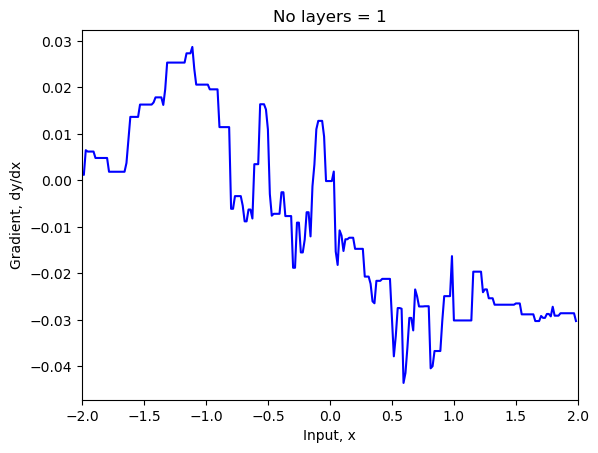

In [14]:
D = 200; K = 1
plot_derivatives(K,D)

### Define and Plot Neural Network Model (24, 200)
Define a neural network model with 24 hidden layer and 200 neurons and plot its gradient

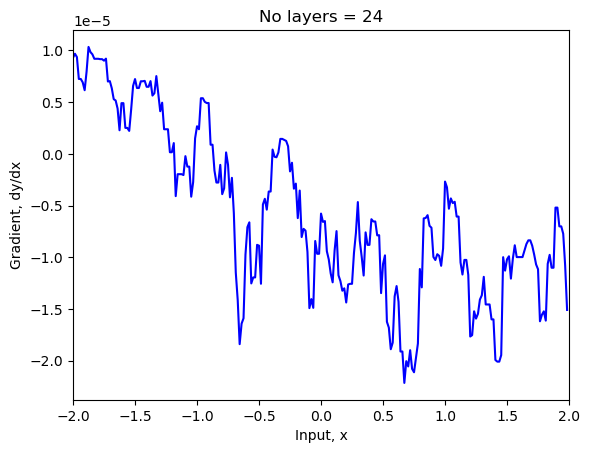

In [15]:
K = 24; D = 200
plot_derivatives(K, D)

### Define and Plot Neural Network Model (50, 200)
Define a neural network model with 50 hidden layer and 200 neurons and plot its gradient

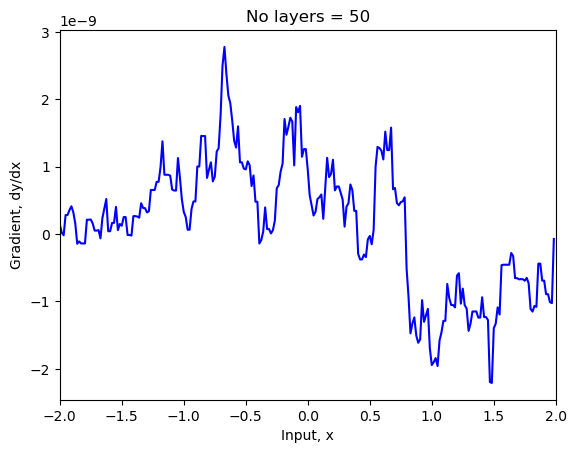

In [16]:
K = 50; D = 200
plot_derivatives(K, D)

### Define Autocorrelation Function
Define an autocorrelation function that measures how correlated neighboring gradients of a neural network model are

In [17]:
def autocorr(dydx):
    ac = np.correlate(dydx, dydx, mode='same')

    return ac

# Define a plotting function to plot the autocorrelation function
def plot_autocorr(K, D):

  # Initialize parameters
  all_weights, all_biases = init_params(K,D)

  x_in = np.arange(-2.0,2.0, 4.0/256)
  x_in = np.resize(x_in, (1,len(x_in)))
  dydx,y = calc_input_output_gradient(x_in, all_weights, all_biases)
  ac = autocorr(np.squeeze(dydx))
  ac = ac / ac[128]

  y = ac[128:]
  x = np.squeeze(x_in)[128:]
  fig,ax = plt.subplots()
  ax.plot(x,y, 'b-')
  ax.set_xlim([0,2])
  ax.set_xlabel('Distance')
  ax.set_ylabel('Autocorrelation')
  ax.set_title('No layers = %d'%(K))
  plt.show()

### Compute Correlation of Neural Network Model's Gradient (2, 200)
Use the autocorrelation function to compute the correlation between neighboring gradients for a neural network model with 2 hidden layers and 200 neurons. Plot the output.

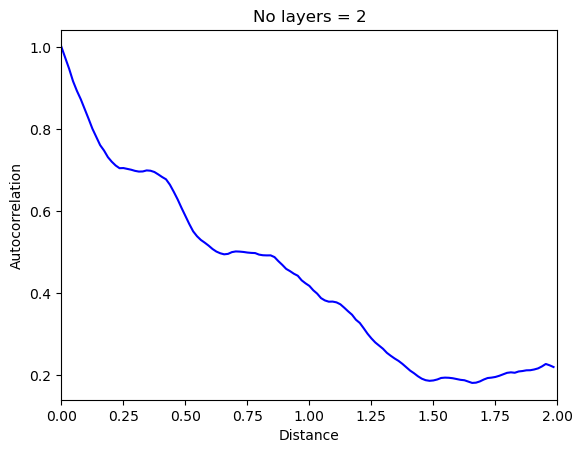

In [18]:
D = 200; K =2
plot_autocorr(K,D)

### Compute Correlation of Neural Network Model's Gradient (50, 200)
Use the autocorrelation function to compute the correlation between neighboring gradients for a neural network model with 50 hidden layers and 200 neurons. Plot the output.

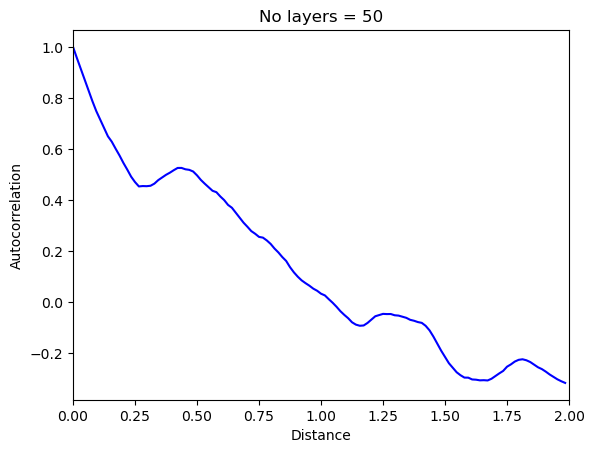

In [19]:
D = 200; K =50
plot_autocorr(K,D)